# Assignment 2: Do you see what I see?

The version of _WordyPy_ that we worked on in the last module was pretty basic, and with our newfound knowledge of image
manipulation it seems reasonable for us to increase the visual appeal here a bit. In this assignment I've modified the
`GameEngine` so that it returns an image to your bot -- your job is to be able to process that image and keep your bot
functioning!

## Requirements

The architecture for the software has changed a bit, here's a breakdown:

### `GameEngine`

I have changed the `GameEngine` class to now return a `PIL.Image` object when the `play` method is called. While it
doesn't sound like much of a change, it means that you need to use image manipulation to determine whether a letter was
in the correct place, in the word but not in the correct place, or not in the word at all.

### `DisplaySpecification`

While I demonstrate below how this looks using the Michigan blue and maize color scheme, I thought it would be nice to
allow future users of _WordPy_ to customize the look and feel, so your code needs to be able to get this new
`DisplaySpecification` and use it to solve the game. In this assignment the `GameEngine` will use the
`DisplaySpecification` defaults, so you can access the member attributes of the class directly.

### `Letter`

This class is unchanged, but you still need to provide the code for it! I recommend copying you solution for assignment
1 here.

### `Bot`

The biggest change to your `Bot` is that the `record_guess_results()` method no longer takes a list of letters, but an
image. To deal with this image you need to implement two helper methods which are private (remember: if a function or
method starts with an underscore in python the intention is for it to be private to the class). Our autograder will be
testing each of these functions to ensure that they work properly, so there's a brief discussion of them here.

#### Writing the method `Bot._tuple_to_str(self, pixels: tuple) -> str`

When you use the python imaging library to explore pixel values you generally get them back as a tuple, with each value
being an integer representation of a single color band. The `GameEngine` uses web hex color codes instead, so you'll
need to translate the tuple representation into a hex string equivalent. **This should be one of the first functions you
write.**

For example, the tuple values of `(186, 12, 47, 255)` in an RGBA image would convert to the hex string value of
`#BA0C2F`. Three things to note about your implementation of this function:

1. It must return hex values in upper case only
2. It must start with the hash mark (#) to indicate they are web hex colors
3. It must only consider the first three values in the tuple, and ignore any other values

#### Writing the method `Bot._process_image(self, guess: str, guess_image: PIL.Image) -> list[Letter]`

The `Bot._process_image` method takes two parameters, a `PIL.Image` which is the output from the game engine, and a
guess, as a string. This method needs to be wired up in your `record_guess_results()` method so that when the game
engine passes a new image you first decode it to a list of letters then record the results.

## Architecture

The new architecture diagram for WordyPy is the following (bold indicates new elements from assignment 1):
![Architecture Diagram of WordyPy for Assignment 2](py3_assignment2.drawio.png)

## Example

### Exploring the new `GameEngine`

It is helpful to know how to use the new `GameEngine` for development. In this assignment you can create a new
`GameEngine` for testing with your target word directly, then you can call its' `evaluate_guess()` method and pass in a
`Guess` for a work which you have chosen. This allows you to see the result in the Jupyter notebook directly using the
`display()` function. Here's a worked example:

```
# create new GameEngine with a target word of "field" and then
# show what it returns when we guess "lives"
guess = Guess("lives")
image = GameEngine("field").evaluate_guess(guess)
print(image)
display(image)
```

Example output: ![Example Output of GameEngine.evaluate_guess()](output1.png)

Note that to run this you _must_ first copy over your working `Letter` implementation from the first assignment, and you
_must_ run the cell below which has the new `GameEngine` implementation.

You will notice that when we print the PIL.Image object we get some information about its parameters (e.g. the image
mode and size). When we call the `display()` the object we see the word has one letter in the correct position (the "I",
shown on a dark blue background) and two letters which are in the word but in the incorrect position (the "L" and the
"E", shown on a maize colored background).

The `_tuple_to_str` private method of your `Bot` is one of the first ones you should write! Here is some code you can
use to test this function:

```python
# the pixel values as an RGBA series
pixels=(0,43,12,255)
print(Bot._tuple_to_str(pixels))
```

Here is an example of the output running on my solution for the assignment:
![Example Output of Bot._tuple_to_str() function](output2.png)


In [15]:
class Letter:
    def __init__(self, letter: str):
        self.letter = letter
        self.in_correct_place = False
        self.in_word = False

    def is_in_correct_place(self):
        return self.in_correct_place

    def is_in_word(self):
        return self.in_word

In [16]:
# This cell has the tests your Letter class

# Check if the Letter class exists
assert "Letter" in dir(), "The Letter class does not exist, did you define it?"

# Check to see if the Letter class can be created
l: Letter
try:
    l = Letter("s")
except:
    assert (
        False
    ), "Unable to create a Letter object with Letter('s'), did you correctly define the Letter class?"

# Check to see if the Letter class has the in_correct_place attribute
assert hasattr(
    l, "in_correct_place"
), "The letter object created has no in_correct_place attribute, but this should be False by default. Did you create this attribute?"


In [17]:
class DisplaySpecification:
    """A dataclass for holding display specifications for WordyPy. The following
    values are defined:
        - block_width: the width of each character in pixels
        - block_height: the height of each character in pixels
        - correct_location_color: the hex code to color the block when it is correct
        - incorrect_location_color: the hex code to color the block when it is in the wrong location but exists in the string
        - incorrect_color: the hex code to color the block when it is not in the string
        - space_between_letters: the amount of padding to put between characters, in pixels
        - word_color: the hex code of the background color of the string
    """

    block_width: int = 80
    block_height: int = 80
    correct_location_color: str = "#00274C"
    incorrect_location_color: str = "#FFCB05"
    incorrect_color: str = "#D3D3D3"
    space_between_letters: int = 5
    word_color: str = "#FFFFFF"

In [18]:
from PIL import Image
class Bot:
    def __init__(self, word_list_file: str, display_spec: DisplaySpecification):
        self.word_list = list(
            map(lambda x: x.strip().upper(), open(word_list_file, "r").readlines())
        )
        self.display_spec = display_spec
        self.previous_guesses = []  # Keep track of guesses made so far

    @staticmethod
    def _tuple_to_str(pixels: tuple) -> str:
        return f"#{''.join(f'{val:02X}' for val in pixels[:3])}"

    def _process_image(self, guess: str, guess_image: Image.Image) -> list[Letter]:
        letters = []
        for i, letter_char in enumerate(guess):
            pixel_data = guess_image.getpixel((i * self.display_spec.block_width, 0))
            hex_color = self._tuple_to_str(pixel_data)

            letter = Letter(letter_char)
            if hex_color == self.display_spec.correct_location_color:
                letter.in_correct_place = True
            elif hex_color == self.display_spec.incorrect_location_color:
                letter.in_word = True
            letters.append(letter)
        return letters

    def record_guess_results(self, guess: str, guess_image: Image.Image):
        letters = self._process_image(guess, guess_image)
        # Store or use the letter results for future guessing logic
        self.previous_guesses.append((guess, letters))

    def make_guess(self) -> str:
        # Implement the guessing logic based on previous results
        # For simplicity, let's just return the next word from the word list that hasn't been guessed yet
        for word in self.word_list:
            if word not in [guess for guess, _ in self.previous_guesses]:
                return word
        return None  # No more guesses left

In [19]:
from PIL import Image, ImageFont, ImageDraw
import random


class GameEngine:
    """The GameEngine represents a new WordPy game to play."""

    def __init__(self, display_spec: DisplaySpecification = None) -> None:
        """Creates a new WordyPy game engine. If the game_spec is None then
        the engine will use the default color and drawing values, otherwise
        it will override the defaults using the provided specification
        """
        # det the display specification to defaults or user provided values
        if display_spec == None:
            display_spec = DisplaySpecification()
        self.display_spec = display_spec

        self.err_input = False
        self.err_guess = False
        self.prev_guesses = []  # record the previous guesses

    def play(
        self, bot: Bot, word_list_file: str = "words.txt", target_word: str = None
    ) -> Image:
        """Plays a new game, using the supplied bot. By default the GameEngine
        will look in words.txt for the list of allowable words and choose one
        at random. Set the value of target_word to override this behavior and
        choose the word that must be guessed by the bot.
        """

        def format_results(results) -> str:
            """Small function to format the results into a string for quick
            review by caller.
            """
            response = ""
            for letter in results:
                if letter.is_in_correct_place():
                    response = response + letter.letter
                elif letter.is_in_word():
                    response = response + "*"
                else:
                    response = response + "?"
            return response

        # read in the dictionary of allowable words
        word_list: list(str) = list(
            map(lambda x: x.strip().upper(), open(word_list_file, "r").readlines())
        )
        # record the known correct positions
        known_letters: list(str) = [None, None, None, None, None]
        # set of unused letters
        unused_letters = set()

        # assign the target word to a member variable for use later
        if target_word is None:
            target_word = random.choice(word_list).upper()
        else:
            target_word = target_word.upper()
            if target_word not in word_list:
                print(f"Target word {target_word} must be from the word list")
                self.err_input = True
                return

        print(
            f"Playing a game of WordyPy using the word list file of {word_list_file}.\nThe target word for this round is {target_word}\n"
        )

        MAX_GUESSES = 6
        for i in range(1, MAX_GUESSES):
            # ask the bot for it's guess and evaluate
            guess: str = bot.make_guess()

            # print out a line indicating what the guess was
            print(f"Evaluating bot guess of {guess}")

            if guess not in word_list:
                print(f"Guessed word {guess} must be from the word list")
                self.err_guess = True
            elif guess in self.prev_guesses:
                print(f"Guess word cannot be the same one as previously used!")
                self.err_guess = True

            if self.err_guess:
                return

            self.prev_guesses.append(guess)  # record the previous guess
            for j, letter in enumerate(guess):
                if letter in unused_letters:
                    print(
                        f"The bot's guess used {letter} which was previously identified as not used!"
                    )
                    self.err_guess = True
                if known_letters[j] is not None:
                    if letter != known_letters[j]:
                        print(
                            f"Previously identified {known_letters[j]} in the correct position is not used at position {j}!"
                        )
                        self.err_guess = True

                if self.err_guess:
                    return

            # get the results of the guess
            correct, results = self._set_feedback(guess, target_word)

            # print out a line indicating whether the guess was correct or not
            print(f"Was this guess correct? {correct}")

            # get the image to be returned to the caller
            img = self._format_results(results)

            print(f"Sending guess results to bot:\n")
            display(img)

            bot.record_guess_results(guess, img)

            # if they got it correct we can just end
            if correct:
                print(f"Great job, you found the target word in {i} guesses!")
                return

        # if we get here, the bot didn't guess the word
        print(
            f"Thanks for playing! You didn't find the target word in the number of guesses allowed."
        )
        return

    def _set_feedback(self, guess: str, target_word: str) -> tuple[bool, list[Letter]]:
        # whether the complete guess is correct
        # set it to True initially and then switch it to False if any letter doesn't match
        correct: bool = True

        letters = []
        for j in range(len(guess)):
            # create a new Letter object
            letter = Letter(guess[j])

            # check to see if this character is in the same position in the
            # guess and if so set the in_correct_place attribute
            if guess[j] == target_word[j]:
                letter.in_correct_place = True
            else:
                # we know they don't have a perfect answer, so let's update
                # our correct variable for feedback
                correct = False

            # check to see if this character is anywhere in the word
            if guess[j] in target_word:
                letter.in_word = True

            # add this letter to our list of letters
            letters.append(letter)

        return correct, letters

    def _render_letter(self, letter: Letter) -> Image:
        """This function renders a single Letter object as an image."""
        # set color string as appropriate
        color: str = self.display_spec.incorrect_color
        if letter.is_in_correct_place():
            color = self.display_spec.correct_location_color
        elif letter.is_in_word():
            color = self.display_spec.incorrect_location_color

        # now we create a new image of width x height with the given color
        block = Image.new(
            "RGB",
            (self.display_spec.block_width, self.display_spec.block_height),
            color=color,
        )
        # and we actually render that image and get a handle back
        draw = ImageDraw.Draw(block)

        # for the lettering we need to identify the center of the block,
        # so we calculate that as the (X,Y) position to render text
        X: int = self.display_spec.block_width // 2
        Y: int = self.display_spec.block_height // 2

        # we will create a font object for drawing lettering
        FONT_SIZE: int = 50
        font = ImageFont.truetype("assets/roboto_font/Roboto-Bold.ttf", FONT_SIZE)

        # now we can draw the letter and tell PIL we want to have the
        # character centered in the box using the anchor attribute
        draw.text((X, Y), letter.letter, size=FONT_SIZE, anchor="mm", font=font)

        return block

    def _format_results(self, letters: list[Letter]) -> Image:
        """This function does the hard work of converting the list[Letter]
        for a guess into an image.
        """
        # some constants that determine what a word of these letters
        # will look like. The algorithm for rendering a word is that
        # we will render each letter independently and put some spacing between
        # them. This means the total word width is equal to the size of
        # all of the letters and the spacing, and the word height is equal
        # to the size of just a single letter
        WORD_WIDTH: int = (len(letters) * self.display_spec.block_width) + (
            len(letters) - 1
        ) * self.display_spec.space_between_letters
        WORD_HEIGHT: int = self.display_spec.block_height

        # we can use the paste() function to place one PIL.Image on top
        # of another PIL.Image
        word = Image.new(
            "RGB", (WORD_WIDTH, WORD_HEIGHT), color=self.display_spec.word_color
        )
        curr_loc = 0
        for letter in letters:
            # we can render the letter and then paste, setting the location
            # as X,Y position we want to paste it in
            rendered_letter: Image = self._render_letter(letter)
            word.paste(rendered_letter, (curr_loc, 0))
            curr_loc += (
                self.display_spec.block_width + self.display_spec.space_between_letters
            )

        return word

In [20]:
# Tests for Bot class.

# Check if the Bot class exists
assert "Bot" in dir(), "The Bot class does not exist, did you define it?"


Playing a game of WordyPy using the word list file of temp_file.txt.
The target word for this round is DOGGY

Evaluating bot guess of DOGGY
Was this guess correct? True
Sending guess results to bot:



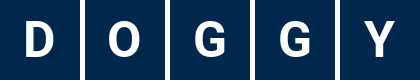

Great job, you found the target word in 1 guesses!


In [21]:
if __name__ == "__main__":
    # Chris's favorite words
    favorite_words = ["doggy", "drive", "daddy", "field", "state"]

    # Write this to a temporary file
    words_file = "temp_file.txt"
    with open(words_file, "w") as file:
        file.writelines("\n".join(favorite_words))

    # Create a new GameEngine with the default DisplaySpecification
    ge = GameEngine()

    # Initialize the student Bot using the display specification from the game engine object
    bot = Bot(words_file, ge.display_spec)

    # Play a game with the Bot
    ge.play(bot, word_list_file=words_file)